In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

# Generate dataset and grid
torch.manual_seed(0)  # Set a seed for reproducibility
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x):
    torch.manual_seed(0)  # Reset seed for consistent randomness
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values
torch.manual_seed(0)  # Reset seed for consistent randomness
Y = torch.stack([target_toy(x) for x in X])


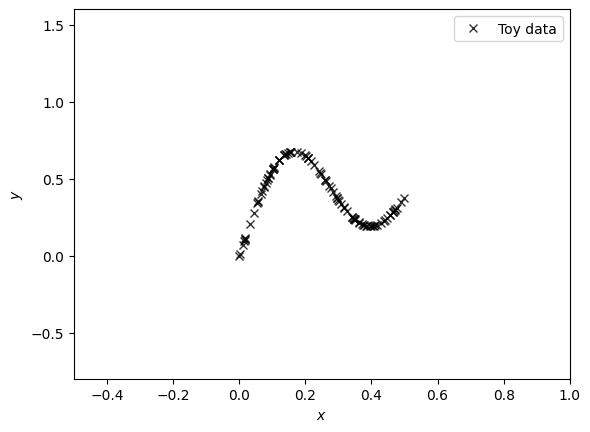

In [2]:
# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

In [3]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class Model(nn.Module):
    def __init__(self, beta):
        super(Model, self).__init__()
        self.prior = GenericNet(input_dim=1)  # Specify the input dimension
        self.trainable = GenericNet(input_dim=1)  # Specify the input dimension
        self.beta = beta

    def forward(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2

